In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy as sc

In [2]:
def d1(s, k, sigma, t, r):
    """
    Computes d1 in BS model
    
    Inputs:
    - s0: spot (initial underlying asset price)
    - k: strike
    - sigma: volatility of underlying
    - t: time to maturity
    - r: risk free rate

    Output:
    - d1
    """
    return (np.log(s/k) + (r + (sigma**2)/2)*t)/(sigma*np.sqrt(t))

def d2(s, k, sigma, t, r):
    """
    Computes d2 in BS model
    """
    return d1(s, k, sigma, t, r) - sigma*np.sqrt(t)

def call(s, k, sigma, t, r):
    """
    Computes call premium with BS model
    """
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    return s*norm.cdf(d1_) - k*np.exp(-r*t)*norm.cdf(d2_)

def put(s, k, sigma, t, r):
    """
    Computes put premium with BS model
    """
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    return - s*norm.cdf(-d1_) + k*np.exp(-r*t)*norm.cdf(-d2_)

def pdi(s, k, b, sigma, t, r):
    """
    Computes put down in premium with BS model
    """
    d1_ = d1(s, b, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    return - s*norm.cdf(-d1_) + k*np.exp(-r*t)*norm.cdf(-d2_)

def proba_ITM(s, k, sigma, t, r, option="call"):
    """
    Computes probability of option ITM : 
    Call : S_T > K ; Put : S_T < K
    """
    d2_ = d2(s, k, sigma, t, r)
    if option == "call":
        return norm.cdf(d2_)
    elif option == "put":
        return norm.cdf(-d2_)
    else:
        print("Option not supported")

def compute_delta(s, k, sigma, t, r, option="call"):
    d1_ = d1(s, k, sigma, t, r)
    if option == "call":
        return norm.cdf(d1_)
    elif option == "put":
        return -norm.cdf(-d1_)
    elif option == "both":
        return np.array([norm.cdf(d1_), -norm.cdf(-d1_)]).T
    else:
        print("Option not supported")
        
def compute_vega(s, k, sigma, t, r):
    d1_ = d1(s, k, sigma, t, r)
    vega = s*norm.pdf(d1_)*np.sqrt(t)*0.01
    return vega

def compute_gamma(s, k, sigma, t, r):
    d1_ = d1(s, k, sigma, t, r)
    gamma = norm.pdf(d1_)/(s*sigma*np.sqrt(t))
    return gamma

def compute_rho(s, k, sigma, t, r, option="call"):
    d2_ = d2(s, k, sigma, t, r)
    if option == "call":
        rho = k*t*np.exp(-r*t)*norm.cdf(d2_)*0.01
        return rho
    elif option == "put":
        rho = -k*t*np.exp(-r*t)*norm.cdf(-d2_)*0.01
        return rho
    elif option == "both":
        rho_c = k*t*np.exp(-r*t)*norm.cdf(d2_)*0.01
        rho_p = -k*t*np.exp(-r*t)*norm.cdf(-d2_)*0.01
        return np.array([rho_c, rho_p]).T
    else:
        print("Option not supported")
        
def compute_theta(s, k, sigma, t, r, option="call"):
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(t)
    if option == "call":
        theta = -s*norm.pdf(d1_)*0.5*sigma/np.sqrt(t) - r*k*np.exp(-r*t)*norm.cdf(d2_)
        return theta
    elif option == "put":
        theta = -s*norm.pdf(d1_)*0.5*sigma/np.sqrt(t) + r*k*np.exp(-r*t)*norm.cdf(-d2_)
        return theta
    elif option =="both":
        theta_c = -s*norm.pdf(d1_)*0.5*sigma/np.sqrt(t) - r*k*np.exp(-r*t)*norm.cdf(d2_)
        theta_p = -s*norm.pdf(d1_)*0.5*sigma/np.sqrt(t) + r*k*np.exp(-r*t)*norm.cdf(-d2_)
        return np.array([theta_c, theta_p]).T
    else:
        print("Option not supported")


def compute_daily_theta(s, k, sigma, t, r, option="call"):
    return compute_theta(s, k, sigma, t, r, option=option)/252

In [27]:
s = 100
sigma = 0.12 # 252 trading days
T = 3/12
r = 0.04
k = s*np.exp(r*T)
implied_daily_move = sigma/np.sqrt(252)
print(f"ATM Forward: {round(k, 2)}")
print(f"Implied daily move: {100*round(implied_daily_move, 4)}%")
print(f"Call price: {round(call(s, k, sigma, T, r), 4)}")
print(f"Put price: {round(put(s, k, sigma, T, r), 4)}")

ATM Forward: 101.01
Implied daily move: 0.76%
Call price: 2.3933
Put price: 2.3933


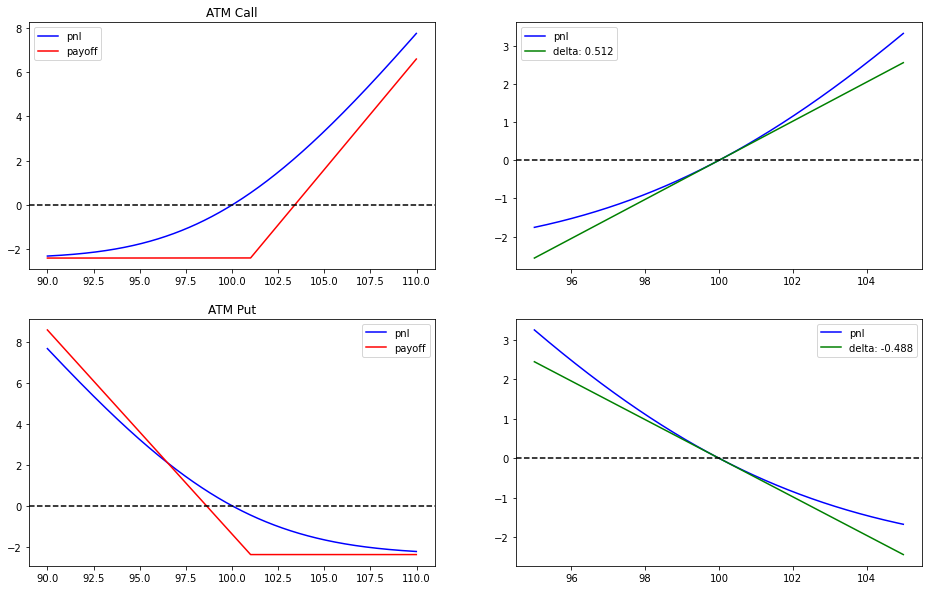

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

spot = np.arange(90, 110, 0.01)
pnl = call(spot, k, sigma, T, r) - call(s, k, sigma, T, r)
call_po = np.maximum(spot-k, 0) - call(s, k, sigma, T, r)
axs[0,0].plot(spot, pnl, c="b", label="pnl")
axs[0,0].plot(spot, call_po, c='r', label="payoff")
axs[0,0].axhline(0, linestyle="--", c="black")
axs[0,0].legend()

spot = np.arange(95, 105, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="call")
pnl = call(spot, k, sigma, T, r) - call(s, k, sigma, T, r)
delta_pnl = (spot-s)*delta
axs[0, 1].plot(spot, pnl, c="b", label="pnl")
axs[0, 1].plot(spot, delta_pnl, c='g', label=f"delta: {round(delta, 4)}")
axs[0, 1].axhline(0, linestyle="--", c="black")
axs[0, 1].legend()
axs[0, 0].set_title("ATM Call")

spot = np.arange(90, 110, 0.01)
pnl = put(spot, k, sigma, T, r) - put(s, k, sigma, T, r)
call_po = np.maximum(-spot+k, 0) - put(s, k, sigma, T, r)
axs[1, 0].plot(spot, pnl, c="b", label="pnl")
axs[1, 0].plot(spot, call_po, c='r', label="payoff")
axs[1, 0].axhline(0, linestyle="--", c="black")
axs[1, 0].legend()

spot = np.arange(95, 105, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="put")
pnl = put(spot, k, sigma, T, r) - put(s, k, sigma, T, r)
delta_pnl = (spot-s)*delta
axs[1, 1].plot(spot, pnl, c="b", label="pnl")
axs[1, 1].plot(spot, delta_pnl, c='g', label=f"delta: {round(delta, 4)}")
axs[1, 1].axhline(0, linestyle="--", c="black")
axs[1, 1].legend()
axs[1, 0].set_title("ATM Put")

plt.show()

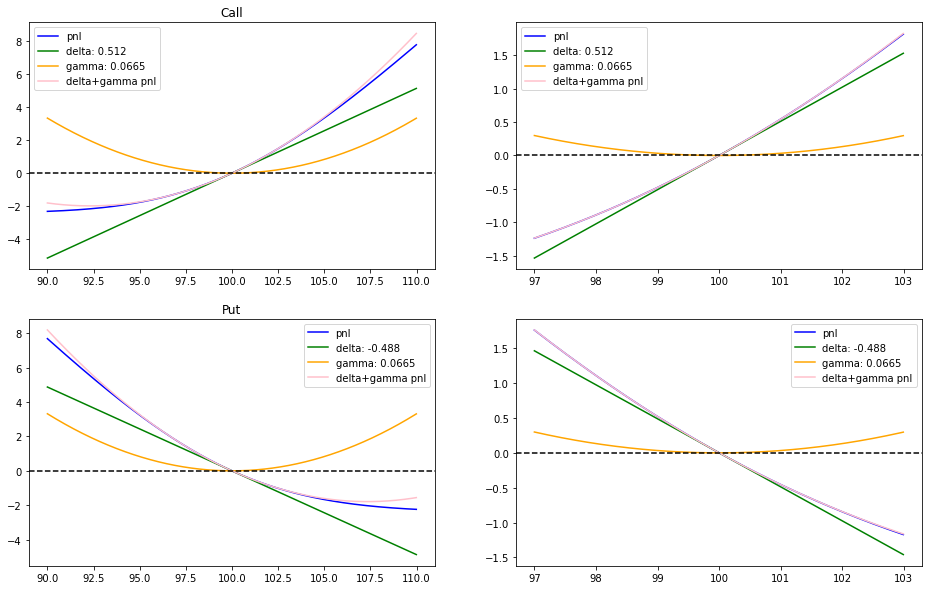

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

spot = np.arange(90, 110, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="call")
gamma = compute_gamma(s, k, sigma, T, r)
pnl = call(spot, k, sigma, T, r) - call(s, k, sigma, T, r)
delta_pnl = (spot-s)*delta
gamma_pnl = ((spot-s)**2)*gamma/2
delta_gamma_pnl = delta_pnl + gamma_pnl
axs[0, 0].plot(spot, pnl, c="b", label="pnl")
axs[0, 0].plot(spot, delta_pnl, c='g', label=f"delta: {round(delta, 4)}")
axs[0, 0].plot(spot, gamma_pnl, c='orange', label=f"gamma: {round(gamma, 4)}")
axs[0, 0].plot(spot, delta_gamma_pnl, c='pink', label="delta+gamma pnl")
axs[0, 0].axhline(0, linestyle="--", c="black")
axs[0, 0].legend()

spot = np.arange(97, 103, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="call")
gamma = compute_gamma(s, k, sigma, T, r)
pnl = call(spot, k, sigma, T, r) - call(s, k, sigma, T, r)
delta_pnl = (spot-s)*delta
gamma_pnl = ((spot-s)**2)*gamma/2
delta_gamma_pnl = delta_pnl + gamma_pnl
axs[0, 1].plot(spot, pnl, c="b", label="pnl")
axs[0, 1].plot(spot, delta_pnl, c='g', label=f"delta: {round(delta, 4)}")
axs[0, 1].plot(spot, gamma_pnl, c='orange', label=f"gamma: {round(gamma, 4)}")
axs[0, 1].plot(spot, delta_gamma_pnl, c='pink', label="delta+gamma pnl")
axs[0, 1].axhline(0, linestyle="--", c="black")
axs[0, 1].legend()
axs[0, 0].set_title("Call")

spot = np.arange(90, 110, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="put")
gamma = compute_gamma(s, k, sigma, T, r)
pnl = put(spot, k, sigma, T, r) - put(s, k, sigma, T, r)
delta_pnl = (spot-s)*delta
gamma_pnl = ((spot-s)**2)*gamma/2
delta_gamma_pnl = delta_pnl + gamma_pnl
axs[1, 0].plot(spot, pnl, c="b", label="pnl")
axs[1, 0].plot(spot, delta_pnl, c='g', label=f"delta: {round(delta, 4)}")
axs[1, 0].plot(spot, gamma_pnl, c='orange', label=f"gamma: {round(gamma, 4)}")
axs[1, 0].plot(spot, delta_gamma_pnl, c='pink', label="delta+gamma pnl")
axs[1, 0].axhline(0, linestyle="--", c="black")
axs[1, 0].legend()

spot = np.arange(97, 103, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="put")
gamma = compute_gamma(s, k, sigma, T, r)
pnl = put(spot, k, sigma, T, r) - put(s, k, sigma, T, r)
delta_pnl = (spot-s)*delta
gamma_pnl = ((spot-s)**2)*gamma/2
delta_gamma_pnl = delta_pnl + gamma_pnl
axs[1, 1].plot(spot, pnl, c="b", label="pnl")
axs[1, 1].plot(spot, delta_pnl, c='g', label=f"delta: {round(delta, 4)}")
axs[1, 1].plot(spot, gamma_pnl, c='orange', label=f"gamma: {round(gamma, 4)}")
axs[1, 1].plot(spot, delta_gamma_pnl, c='pink', label="delta+gamma pnl")
axs[1, 1].axhline(0, linestyle="--", c="black")
axs[1, 1].legend()
axs[1, 0].set_title("Put")

plt.show()

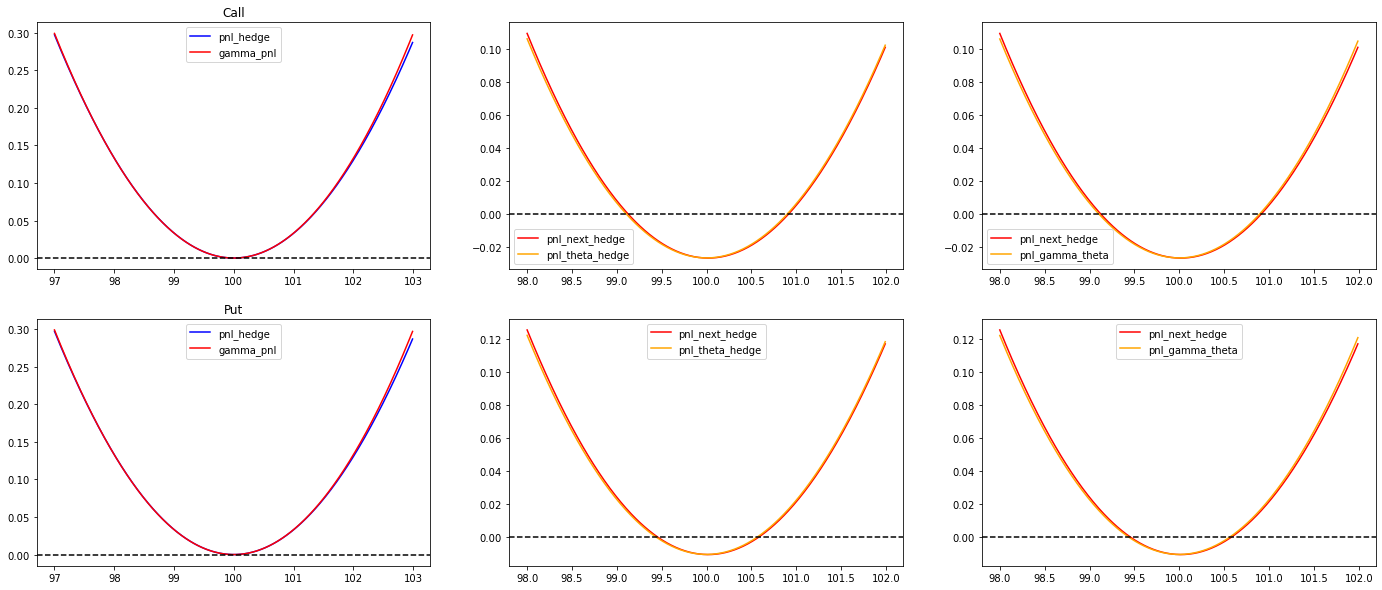

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(24, 10))

spot = np.arange(97, 103, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="call")
gamma = compute_gamma(s, k, sigma, T, r)
pnl = call(spot, k, sigma, T, r) - call(s, k, sigma, T, r)
gamma_pnl = ((spot-s)**2)*gamma/2
delta_hedge = -(spot-s)*delta
pnl_hedge = pnl + delta_hedge
axs[0, 0].plot(spot, pnl_hedge, c="b", label="pnl_hedge")
axs[0, 0].plot(spot, gamma_pnl, c="r", label="gamma_pnl")
axs[0, 0].axhline(0, linestyle="--", c="black")
axs[0, 0].legend()

spot = np.arange(98, 102, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="call")
theta = compute_daily_theta(s, k, sigma, T, r, option="call")
pnl_next = call(spot, k, sigma, T - 1/252, r) - call(s, k, sigma, T, r)
pnl_theta = call(spot, k, sigma, T, r) - call(s, k, sigma, T, r) + theta
delta_hedge = -(spot-s)*delta
pnl_next_hedge = pnl_next + delta_hedge
pnl_theta_hedge = pnl_theta + delta_hedge
axs[0, 1].plot(spot, pnl_next_hedge, c="r", label="pnl_next_hedge")
axs[0, 1].plot(spot, pnl_theta_hedge, c="orange", label="pnl_theta_hedge")
axs[0, 1].axhline(0, linestyle="--", c="black")
axs[0, 1].legend()

spot = np.arange(98, 102, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="call")
gamma = compute_gamma(s, k, sigma, T, r)
theta = compute_daily_theta(s, k, sigma, T, r, option="call")
pnl_next = call(spot, k, sigma, T - 1/252, r) - call(s, k, sigma, T, r)
gamma_pnl = ((spot-s)**2)*gamma/2
pnl_gamma_theta = theta + gamma_pnl
delta_hedge = -(spot-s)*delta
pnl_next_hedge = pnl_next + delta_hedge
axs[0, 2].plot(spot, pnl_next_hedge, c="r", label="pnl_next_hedge")
axs[0, 2].plot(spot, pnl_gamma_theta, c="orange", label="pnl_gamma_theta")
axs[0, 2].axhline(0, linestyle="--", c="black")
axs[0, 2].legend()
axs[0, 0].set_title("Call")


spot = np.arange(97, 103, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="put")
gamma = compute_gamma(s, k, sigma, T, r)
pnl = put(spot, k, sigma, T, r) - put(s, k, sigma, T, r)
gamma_pnl = ((spot-s)**2)*gamma/2
delta_hedge = -(spot-s)*delta
pnl_hedge = pnl + delta_hedge
axs[1, 0].plot(spot, pnl_hedge, c="b", label="pnl_hedge")
axs[1, 0].plot(spot, gamma_pnl, c="r", label="gamma_pnl")
axs[1, 0].axhline(0, linestyle="--", c="black")
axs[1, 0].legend()

spot = np.arange(98, 102, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="put")
theta = compute_daily_theta(s, k, sigma, T, r, option="put")
pnl_next = put(spot, k, sigma, T - 1/252, r) - put(s, k, sigma, T, r)
pnl_theta = put(spot, k, sigma, T, r) - put(s, k, sigma, T, r) + theta
delta_hedge = -(spot-s)*delta
pnl_next_hedge = pnl_next + delta_hedge
pnl_theta_hedge = pnl_theta + delta_hedge
axs[1, 1].plot(spot, pnl_next_hedge, c="r", label="pnl_next_hedge")
axs[1, 1].plot(spot, pnl_theta_hedge, c="orange", label="pnl_theta_hedge")
axs[1, 1].axhline(0, linestyle="--", c="black")
axs[1, 1].legend()

spot = np.arange(98, 102, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="put")
gamma = compute_gamma(s, k, sigma, T, r)
theta = compute_daily_theta(s, k, sigma, T, r, option="put")
pnl_next = put(spot, k, sigma, T - 1/252, r) - put(s, k, sigma, T, r)
gamma_pnl = ((spot-s)**2)*gamma/2
pnl_gamma_theta = theta + gamma_pnl
delta_hedge = -(spot-s)*delta
pnl_next_hedge = pnl_next + delta_hedge
axs[1, 2].plot(spot, pnl_next_hedge, c="r", label="pnl_next_hedge")
axs[1, 2].plot(spot, pnl_gamma_theta, c="orange", label="pnl_gamma_theta")
axs[1, 2].axhline(0, linestyle="--", c="black")
axs[1, 2].legend()
axs[1, 0].set_title("Put")

plt.show()

$$
PNL = PNL_{\Gamma} + PNL_{\Theta} \rightarrow
PNL > 0 \Leftrightarrow PNL_{\Gamma} > -PNL_{\Theta}
$$
$$
\Leftrightarrow \frac{\Gamma}{2} (S_{t+1} - S_t)^2  > -\Theta
\Leftrightarrow \frac{\Gamma}{2} (S_t R_t)^2  > -\Theta
\Leftrightarrow R_t > \frac{\sqrt{-\frac{2\Theta}{\Gamma}}}{S_t} = ThresholdMove
$$
$$
With
$$
$$
\Theta_{call} = -(S_t*ImpliedMove)^2 \frac{\Gamma}{2} - X \quad, X > 0
$$
$$
\Theta_{put} = -(S_t*ImpliedMove)^2 \frac{\Gamma}{2} + Y \quad, Y > 0
$$
$$
\Rightarrow ThresholdMove_{call} = \frac{\sqrt{-\frac{2\Theta_{call}}{\Gamma}}}{S_t} = \frac{\sqrt{(S_t*IM)^2 + \frac{2X}{\Gamma}}}{S_t} \approx \frac{S_t*IM(1 + \frac{X}{\Gamma (S_t*IM)^2})}{S_t} = IM + \frac{X}{\Gamma S^2 IM} > IM
$$
$$
\Rightarrow ThresholdMove_{put} = \frac{\sqrt{-\frac{2\Theta_{put}}{\Gamma}}}{S_t} = \frac{\sqrt{(S_t*IM)^2 - \frac{2Y}{\Gamma}}}{S_t} \approx \frac{S_t*IM(1 - \frac{Y}{\Gamma (S_t*IM)^2})}{S_t} = IM - \frac{Y}{\Gamma S^2 IM} < IM
$$

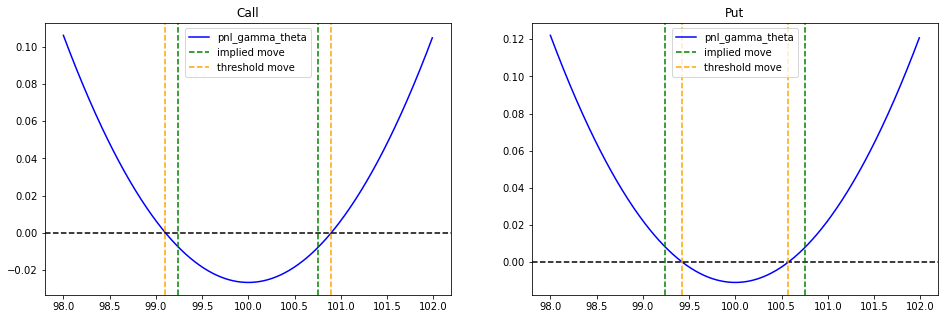

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

spot = np.arange(98, 102, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="call")
gamma = compute_gamma(s, k, sigma, T, r)
theta = compute_daily_theta(s, k, sigma, T, r, option="call")
gamma_pnl = ((spot-s)**2)*gamma/2
pnl_gamma_theta = theta + gamma_pnl
delta_hedge = -(spot-s)*delta
ir = np.sqrt(-2*theta/gamma)/s
axs[0].plot(spot, pnl_gamma_theta, c="b", label="pnl_gamma_theta")
axs[0].axhline(0, linestyle="--", c="black")
axs[0].axvline(s*(1+implied_daily_move), linestyle="--", c="green", label="implied move")
axs[0].axvline(s*(1-implied_daily_move), linestyle="--", c="green")
axs[0].axvline(s*(1+ir), linestyle="--", c="orange", label="threshold move")
axs[0].axvline(s*(1-ir), linestyle="--", c="orange")
axs[0].legend()
axs[0].set_title("Call")

spot = np.arange(98, 102, 0.01)
delta = compute_delta(s, k, sigma, T, r, option="put")
gamma = compute_gamma(s, k, sigma, T, r)
theta = compute_daily_theta(s, k, sigma, T, r, option="put")
gamma_pnl = ((spot-s)**2)*gamma/2
pnl_gamma_theta = theta + gamma_pnl
delta_hedge = -(spot-s)*delta
ir = np.sqrt(-2*theta/gamma)/s
axs[1].plot(spot, pnl_gamma_theta, c="b", label="pnl_gamma_theta")
axs[1].axhline(0, linestyle="--", c="black")
axs[1].axvline(s*(1+implied_daily_move), linestyle="--", c="green", label="implied move")
axs[1].axvline(s*(1-implied_daily_move), linestyle="--", c="green")
axs[1].axvline(s*(1+ir), linestyle="--", c="orange", label="threshold move")
axs[1].axvline(s*(1-ir), linestyle="--", c="orange")
axs[1].legend()
axs[1].set_title("Put")

plt.show()

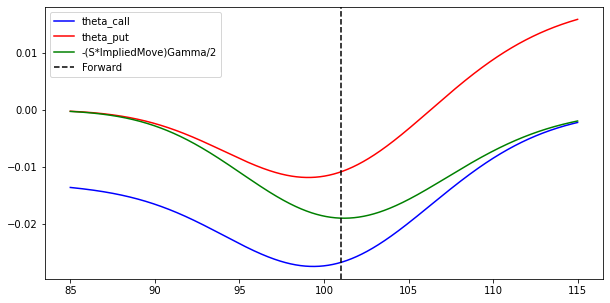

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

spot = np.arange(85, 115, 0.01)
theta_call = compute_daily_theta(s, spot, sigma, T, r, option="call")
theta_put = compute_daily_theta(s, spot, sigma, T, r, option="put")
gamma = compute_gamma(s, spot, sigma, T, r)
common_theta = -((s*implied_daily_move)**2)*gamma/2
ax.plot(spot, theta_call, c="b", label="theta_call")
ax.plot(spot, theta_put, c="r", label="theta_put")
ax.plot(spot, common_theta, c="g", label="-(S*ImpliedMove)^2 Gamma/2")
ax.axvline(k, linestyle="--", c="black", label="Forward")
ax.legend()

plt.show()


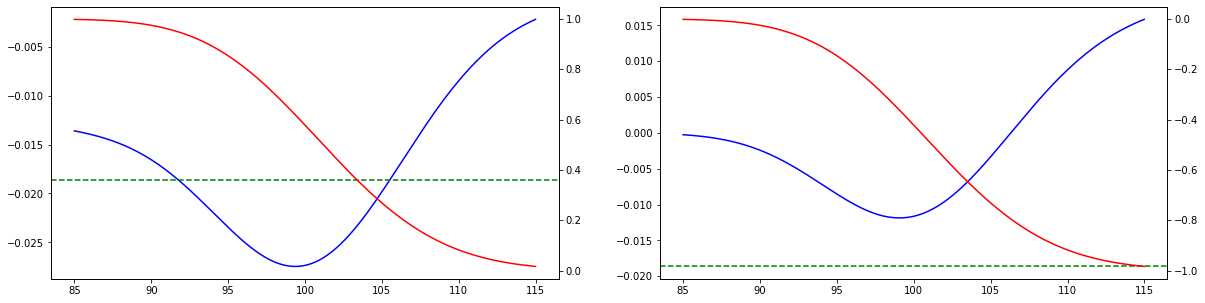

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

spot = np.arange(85, 115, 0.01)
theta = compute_daily_theta(s, spot, sigma, T, r, option="call")
delta = compute_delta(s, spot, sigma, T, r, option="call")
good_theta = -((s*implied_daily_move)**2)*gamma/2
ax[0].plot(spot, theta, c="b", label="theta")
ax2 = ax[0].twinx()
ax2.plot(spot, delta, c="r", label="delta")
ax[0].axhline(good_theta, linestyle="--", c="green")

spot = np.arange(85, 115, 0.01)
theta = compute_daily_theta(s, spot, sigma, T, r, option="put")
delta = compute_delta(s, spot, sigma, T, r, option="put")
good_theta = -((s*implied_daily_move)**2)*gamma/2
ax[1].plot(spot, theta, c="b", label="theta")
ax2 = ax[1].twinx()
ax2.plot(spot, delta, c="r", label="delta")
ax[1].axhline(good_theta, linestyle="--", c="green")

plt.show()


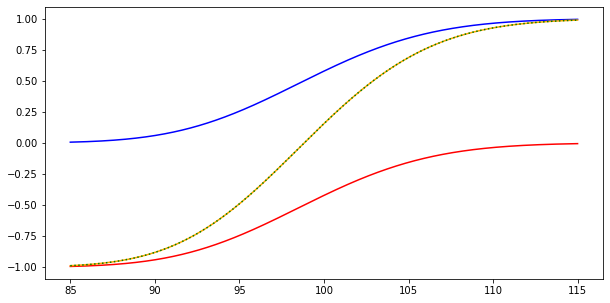

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

spot = np.arange(85, 115, 0.01)
delta_call = compute_delta(spot, s, sigma, T, r, option="call")
delta_put= compute_delta(spot, s, sigma, T, r, option="put")
delta_sum = delta_put + delta_call
double_delta = 2*delta_call - 1

ax.plot(spot, delta_call, c="b")
ax.plot(spot, delta_put, c="r")
ax.plot(spot, delta_sum, c="orange")
ax.plot(spot, double_delta, c="g", linestyle=":")
plt.show()